# How to calculate the disconnected (= Gaussian) power spectrum covariance for cubic geometry

Reference: [Yin Li+18](https://arxiv.org/abs/1811.05714).

## Given an input theory $P(k)$

In [14]:
from matplotlib import pyplot as plt

from jax import numpy as jnp
from jaxpower import MeshAttrs, Mesh2SpectrumPole, Mesh2SpectrumPoles, BinMesh2SpectrumPoles, compute_spectrum2_covariance

def get_theory(kmax=0.3, dk=0.005):
    # Return theory power spectrum
    from cosmoprimo.fiducial import DESI
    cosmo = DESI(engine='eisenstein_hu')
    z = 1.
    pk1d = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
    ellsin = (0, 2, 4)
    edgesin = jnp.arange(0., kmax, dk)
    edgesin = jnp.column_stack([edgesin[:-1], edgesin[1:]])
    kin = jnp.mean(edgesin, axis=-1)
    f, b = cosmo.growth_rate(z), 1.5
    beta = f / b
    shotnoise = (1e-3)**(-1)
    pk = pk1d(kin)
    # *Including* shot noise in the covariance matrix
    poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk + shotnoise,
                        (4. / 3. * beta + 4. / 7. * beta ** 2) * pk,
                        8. / 35 * beta ** 2 * pk])
    theory = []
    for ell, value in zip(ellsin, poles):
        theory.append(Mesh2SpectrumPole(k=kin, k_edges=edgesin, num_raw=value, ell=ell))
    return Mesh2SpectrumPoles(theory)

# Mesh used to estimate P(k) --- for binning effects
mattrs = MeshAttrs(boxsize=1000., meshsize=128)
# Underlying P(k) theory
theory = get_theory(kmax=mattrs.knyq.max(), dk=0.001)

# Here computing the discrete modes on the grid
bin = BinMesh2SpectrumPoles(mattrs, edges=theory.get(0).edges('k'))
theory = theory.clone(nmodes=[bin.nmodes] * len(theory.ells))

# Covariance matrix with same binning as input theory (dk = 0.001)
covmat = compute_spectrum2_covariance(mattrs, theory, flags=[])
# Then rebin to your actual binning (e.g. dk = 0.005)
covmat = covmat.at.observable.select(k=slice(0, None, 5))

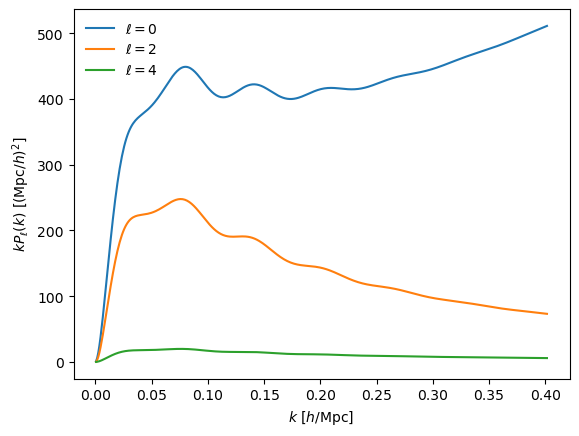

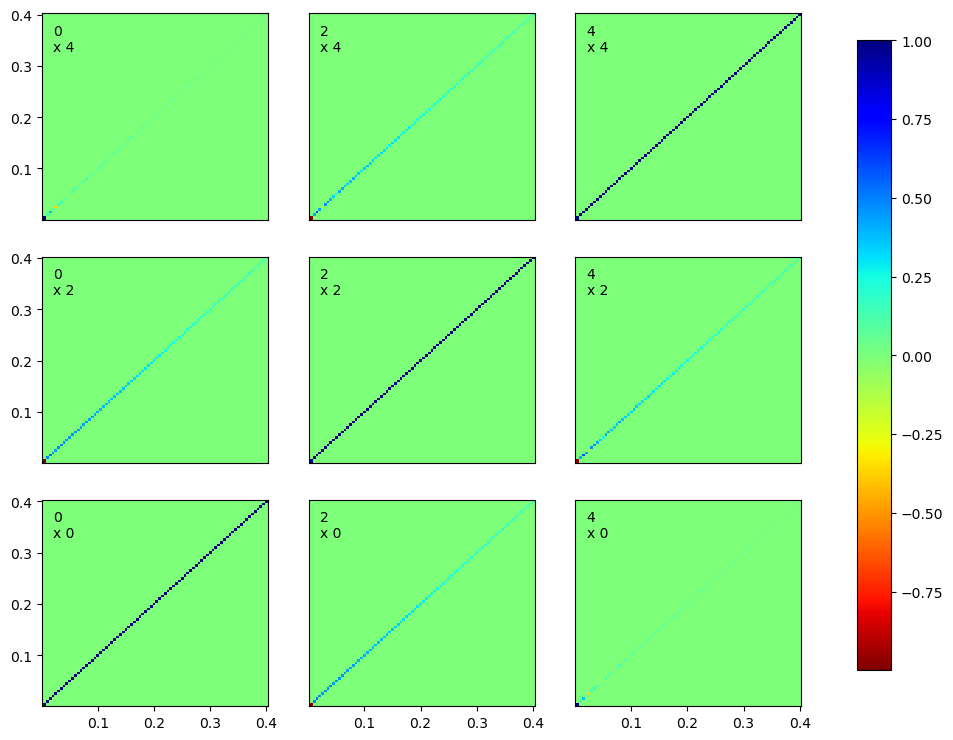

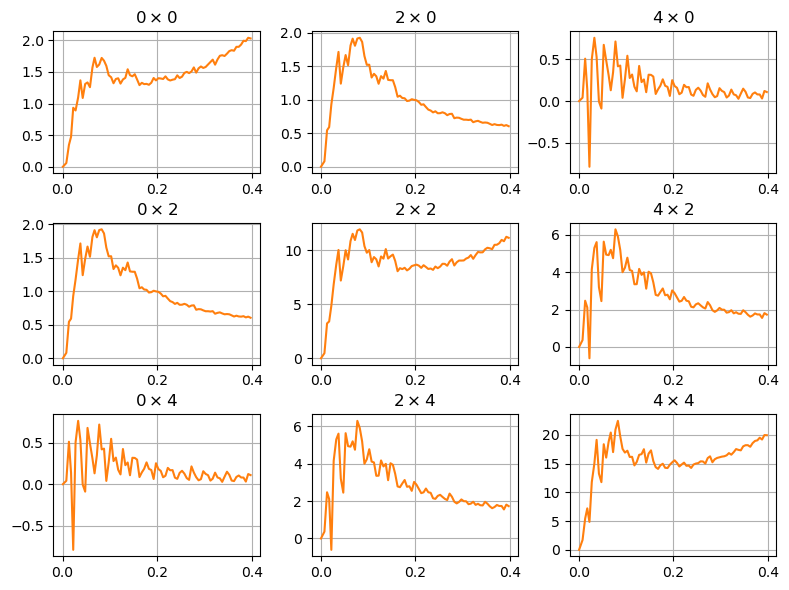

In [2]:
# Plot input theory power spectrum (including shot noise)
theory.plot(show=True)
# Plot covariance matrix
covmat.plot(corrcoef=True, show=True)
# Plot diagonals of the different blocks
covmat.plot_diag(ytransform=lambda x, y: x**4 * y, color='C1', show=True);

In [3]:
# To select the covariance matrix, e.g. 0 < k < 0.3 and ells = (0, 2)
submat = covmat.at.observable.select(k=(0., 0.3)).at.observable.get(ells=[0, 2])
# To access the covariance matrix as an array
array = submat.value()

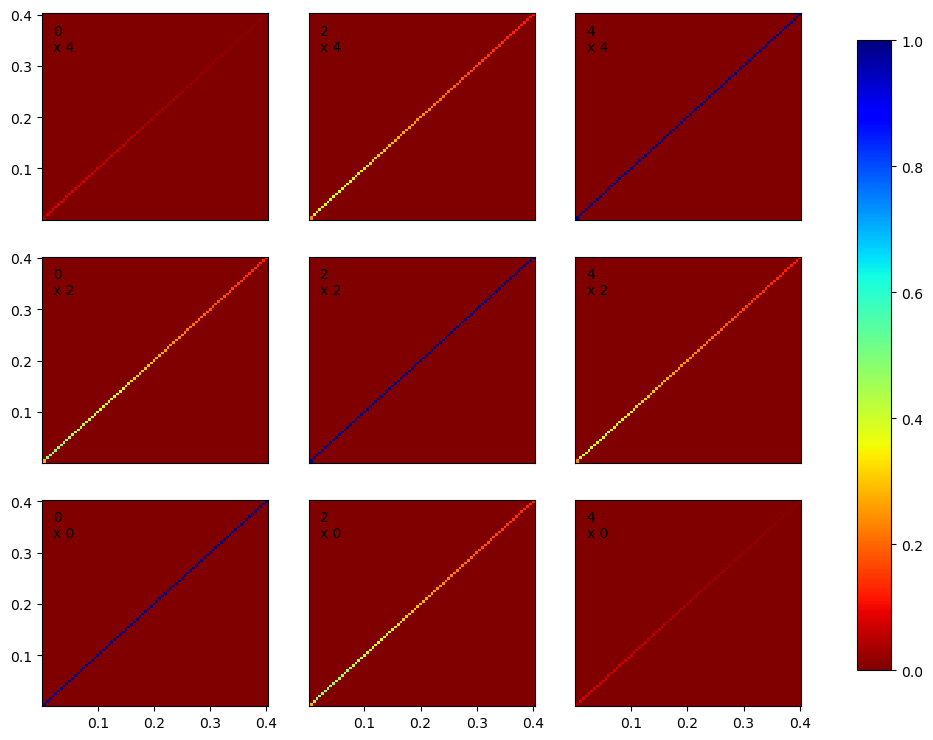

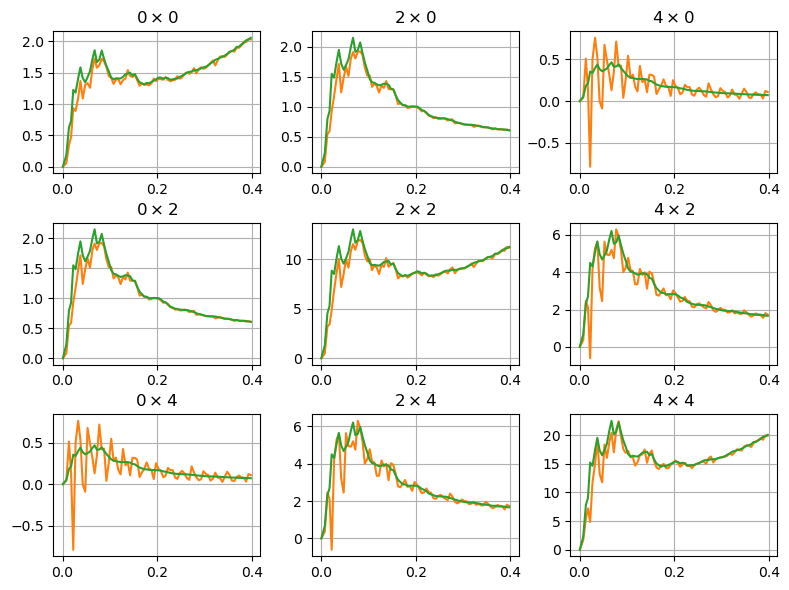

In [4]:
# Oscillations are due to mesh resolution effects, here is the version without mesh resolution

# Covariance matrix with same binning as input theory (dk = 0.001)
covmat_smooth = compute_spectrum2_covariance(mattrs, theory, flags=['smooth'])
# Then rebin to your actual binning (e.g. dk = 0.005)
covmat_smooth = covmat_smooth.at.observable.select(k=slice(0, None, 5))

# Plot covariance matrix
covmat_smooth.plot(corrcoef=True, show=True)
# Plot diagonals of the different blocks
fig = covmat.plot_diag(ytransform = lambda x, y: x**4 * y, color='C1');
covmat_smooth.plot_diag(ytransform = lambda x, y: x**4 * y, color='C2', fig=fig, show=True);

## Estimate the underlying theory $P(k)$ given mock $P(k)$ measurements



In [5]:
# Let's generate some mocks with the above-defined theory
from jaxpower import generate_anisotropic_gaussian_mesh, compute_mesh2_spectrum
from jax import random

mattrs = MeshAttrs(boxsize=1000., meshsize=128)
bin = BinMesh2SpectrumPoles(mattrs, edges={'min': 0, 'step': 0.01}, ells=(0, 2, 4))
list_mocks = []
for imock in range(3):
    seed = random.key(imock)
    los = 'z'
    # Setting unitary_amplitude = True to reduce noise (actually, there is no noise at all, so no need for multiple realizations)
    mesh = generate_anisotropic_gaussian_mesh(mattrs, poles=theory, los=los, seed=seed, unitary_amplitude=True)
    spectrum = compute_mesh2_spectrum(mesh, bin=bin, los=los)
    list_mocks.append(spectrum)

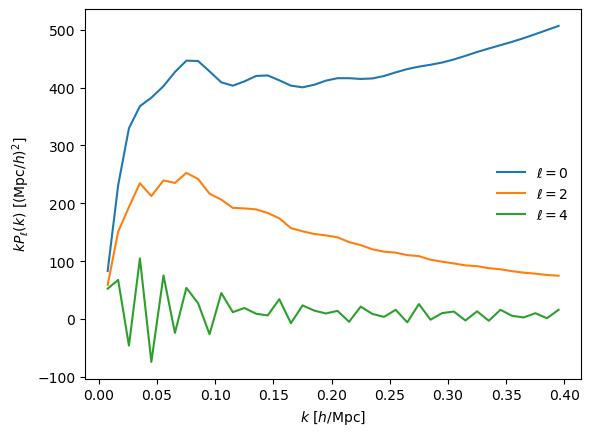

In [6]:
# The mean power spectrum, with oscillations due to mesh resolution effects
mean = spectrum.mean(list_mocks)
mean.plot(show=True);

In [7]:
# Let's try to find the underlying theory. First compute the window matrix.
# Note: all this will be much faster on the GPU!
from jaxpower import compute_mesh2_spectrum_window

# edges and ells for input theory
edgesin = jnp.arange(0., 0.42, 0.005)
ellsin = (0, 2, 4)
# bin is still the binning operator
wmat = compute_mesh2_spectrum_window(mattrs, edgesin=edgesin, ellsin=ellsin, bin=bin, los=los, pbar=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 83/83 [00:17<00:00,  4.66it/s]


In [8]:
# Now we need to assume some functional shape for the theory power spectrum
# Let's "square" the window matrix
wmat_square = wmat.at.theory.match(wmat.observable)  # slice input theory to observed binning

In [9]:
# Invert the square window matrix
observable_to_theory = wmat_square.clone(value=jnp.linalg.inv(wmat_square.value()))

Text(0, 0.5, '$k P_{\\ell}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]')

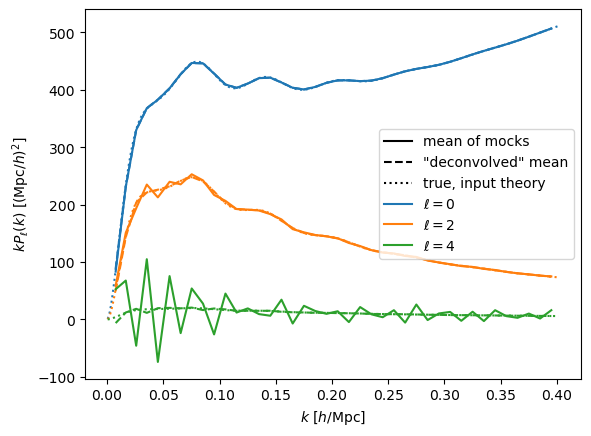

In [10]:
observable_inverse = observable_to_theory.dot(mean, return_type=None)

ax = plt.gca()
ax.plot([], [], color='k', linestyle='-', label='mean of mocks')
ax.plot([], [], color='k', linestyle='--', label='"deconvolved" mean')
ax.plot([], [], color='k', linestyle=':', label='true, input theory')
for ill, ell in enumerate(observable_inverse.ells):
    color = 'C{:d}'.format(ill)
    pole = mean.get(ell)
    ax.plot(pole.coords('k'), pole.coords('k') * pole.value(), color=color, linestyle='-', label='$\ell = {:d}$'.format(ell))
    pole = observable_inverse.get(ell)
    ax.plot(pole.coords('k'), pole.coords('k') * pole.value(), color=color, linestyle='--')
    pole = theory.get(ell)
    ax.plot(pole.coords('k'), pole.coords('k') * pole.value(), color=color, linestyle=':')
ax.legend()
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')

In [11]:
# Let's just do a spline interpolation of the "deconvolved" P(k)
# (one could do something better, fitting some real model given a preliminary covariance matrix)

from scipy import interpolate

def theory_estimated_callable(k):
    # Insert 0 to enforce P(k=0) = 0
    x = jnp.insert(observable_inverse.get(0).coords('k'), 0, 0.)
    y = jnp.stack([jnp.insert(observable_inverse.get(ell).value(), 0, 0.) for ell in observable_inverse.ells])
    return interpolate.interp1d(x, y, kind='cubic', axis=-1, fill_value="extrapolate", assume_sorted=True)(k)

edgesin = jnp.arange(0., 0.4, 0.001)
edgesin = jnp.column_stack([edgesin[:-1], edgesin[1:]])
kin = jnp.mean(edgesin, axis=-1)
ellsin = list(observable_inverse.ells)
theory_estimated = []
for ell, value in zip(ellsin, theory_estimated_callable(kin)):
    theory_estimated.append(Mesh2SpectrumPole(k=kin, k_edges=edgesin, num_raw=value, ell=ell))
theory_estimated = Mesh2SpectrumPoles(theory_estimated)

In [12]:
# Covariance matrix with same binning as input theory (dk = 0.001)
bin = BinMesh2SpectrumPoles(mattrs, edges=theory_estimated.get(0).edges('k'))
theory_estimated = theory_estimated.clone(nmodes=[bin.nmodes] * len(theory_estimated.ells))
covmat_estimated = compute_spectrum2_covariance(mattrs, theory_estimated, flags=[])
# Then rebin to your actual binning (e.g. dk = 0.005)
covmat_estimated = covmat_estimated.at.observable.select(k=slice(0, None, 5))

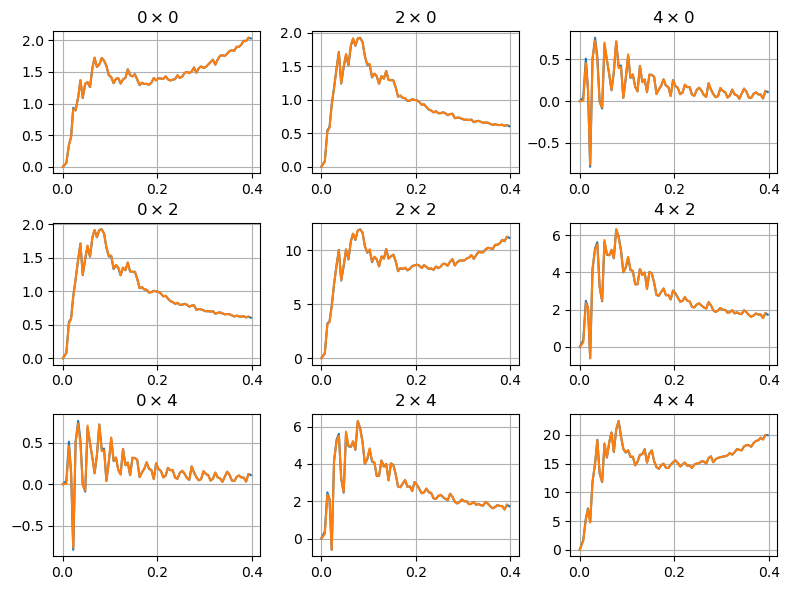

In [13]:
# Plot diagonals of the different blocks
# The 'estimated' covariance is quite close to the 'true' one!
fig = covmat.plot_diag(ytransform=lambda x, y: x**4 * y, color='C0')
covmat_estimated.plot_diag(ytransform=lambda x, y: x**4 * y, color='C1', fig=fig, show=True);